<a href="https://colab.research.google.com/github/ruddysimon/ADS504-machine-learning-deep-learning/blob/ruddy-branch/Fake_news_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import csv

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Understanding

In [3]:
fake_news_df = pd.read_csv("/content/drive/MyDrive/ADS504 - Machine Learning /resource/fake_news.csv")
display(fake_news_df)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [4]:
# check missing values in dataset
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

With 20,800 rows in your dataset, removing all rows with missing values would still leave a substantial amount of data. However, given that the "title" and "text" fields are likely very important for a fake news detection task, it may be better to avoid removing these rows if possible.

**Suggestion:**

For the "title" and "text" columns, replace missing values with a placeholder string such as "missing". This allows us to retain the rows while also acknowledging the absence of this important information.</br>
For the "author" column, replace missing values with another placeholder string like "unknown". The authorship may be less important in determining whether a news story is fake, so this approach allows us to keep the data without making potentially misleading assumptions.

In [5]:
# replace NaN values in 'title' and 'text' with 'missing'
fake_news_df['title'].fillna("", inplace=True)
fake_news_df['text'].fillna("", inplace=True)


In [6]:
# combine 'title' and 'text' into a one single variable
fake_news_df['content'] = fake_news_df['title'] + ' ' + fake_news_df['text']
fake_news_df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [7]:
# drop unnecessary column
fake_news_df.drop(["id", "author"],axis=1,inplace=True)

## Class Imbalance check

1    10413
0    10387
Name: label, dtype: int64


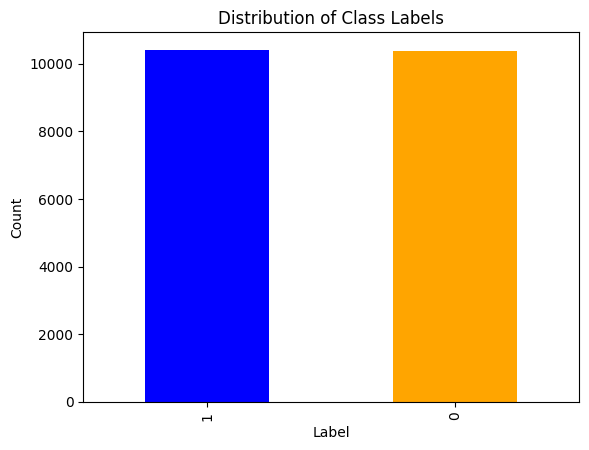

In [8]:
# check the distribution of the class labels
label_count = fake_news_df["label"].value_counts()
print(label_count)

label_count.plot(kind='bar', color=['blue','orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

# Preprocessing

In [9]:
#insignificant words
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

port_stem = PorterStemmer()

def remove_non_alpha(text):
    # remove numbers and punctuation, keep only alphabets
    return re.sub('[^a-zA-Z]+', ' ', text)

def lowercase(text):
    # convert all alphabets into lowercase
    return text.lower()

def remove_stopwords_and_stem(text):
    # split and convert to list
    words = text.split()

    # stem all the words that are not in stopwords
    stemmed_words = [port_stem.stem(word) for word in words if word not in stopwords.words('english')]

    # join the stemmed words back into a string
    return ' '.join(stemmed_words)

def clean_text(content):
    cleaned_content = remove_non_alpha(content)
    cleaned_content = lowercase(cleaned_content)
    cleaned_content = remove_stopwords_and_stem(cleaned_content)
    return cleaned_content


In [11]:
# Apply the preprocessing to the 'content' colum
fake_news_df['content'] = fake_news_df['content'].apply(clean_text)

In [17]:
preprocess_data = fake_news_df.to_csv('/content/drive/MyDrive/ADS504 - Machine Learning /resource/preprocessed_data1.csv',index=False, sep='|', encoding='utf-8')

In [18]:
# fake_news_df = pd.read_csv('/content/drive/MyDrive/ADS504 - Machine Learning /resource/preprocessed_data1.csv', sep='|', encoding='utf-8')
# fake_news_df

,title,author,text,label,content
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,hous dem aid even see comey letter jason chaff...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillari clinton big woman campu breitbar...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fire truth might get fire octo...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,civilian kill singl us airstrik identifi video...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jail fiction unpublish stori wom...
...,...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,rapper trump poster child white supremaci rapp...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,n f l playoff schedul matchup odd new york tim...
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,maci said receiv takeov approach hudson bay ne...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,nato russia hold parallel exercis balkan nato ...


In [12]:
fake_news_df.isnull().sum()


title      0
text       0
label      0
content    0
dtype: int64

In [13]:
fake_news_df.dtypes

title      object
text       object
label       int64
content    object
dtype: object

# Data Partitioning

In [19]:
# data splitting
train_X, test_X, train_y, test_y = train_test_split(fake_news_df['content'], fake_news_df['label'],
                                                    test_size=0.2, random_state = 42, stratify=fake_news_df['label'])


# Text Tokenizer

In [20]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

tokenizer.fit_on_texts(train_X)

# tokenize the training and test data
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_length = int(np.percentile([len(seq) for seq in train_sequences], 95))

# padding the sequences
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [23]:
#####################
###  PARAMS  ###
#####################
sequence_neuron_size = 100
hidden_layer_1 = 32
epochs = 20
batch_size = 256
classifier = 'binary'

In [24]:
def train_model(model,X_train,y_train,X_test, y_test):

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    history = model.fit(X_train, y_train, epochs=epochs,batch_size = batch_size ,validation_split=0.2)#validation_data=(X_test, y_test))
    return model,history

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def performance_history(history,model_type,name):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


def model_evaluation(model,X_test,y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return score


## Running LSTM Network


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()

model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_length))

# LSTM layer
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1037, 128)         2560000   
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 118s 223ms/step - loss: 0.6910 - accuracy: 0.5082 - val_loss: 0.6850 - val_accuracy: 0.5219
Epoch 2/10
520/520 [==============================] - 75s 143ms/step - loss: 0.6716 - accuracy: 0.5260 - val_loss: 0.6758 - val_accuracy: 0.5231
Epoch 3/10
520/520 [==============================] - 59s 114ms/step - loss: 0.6698 - accuracy: 0.5264 - val_loss: 0.6778 - val_accuracy: 0.5245
Epoch 4/10
520/520 [==============================] - 43s 83ms/step - loss: 0.6618 - accuracy: 0.5329 - val_loss: 0.6905 - val_accuracy: 0.5084
Epoch 5/10
520/520 [==============================] - 35s 67ms/step - loss: 0.6604 - accuracy: 0.5356 - val_loss: 0.6867 - val_accuracy: 0.5224
Epoch 6/10
520/520 [==============================] - 33s 64ms/step - loss: 0.6626 - accuracy: 0.5293 - val_loss: 0.6881 - val_accuracy: 0.5221
Epoch 7/10
520/520 [==============================] - 30s 58ms/step - loss: 0.6597 - accuracy: 0.5254 - val_loss: 0.6910 - val_accur

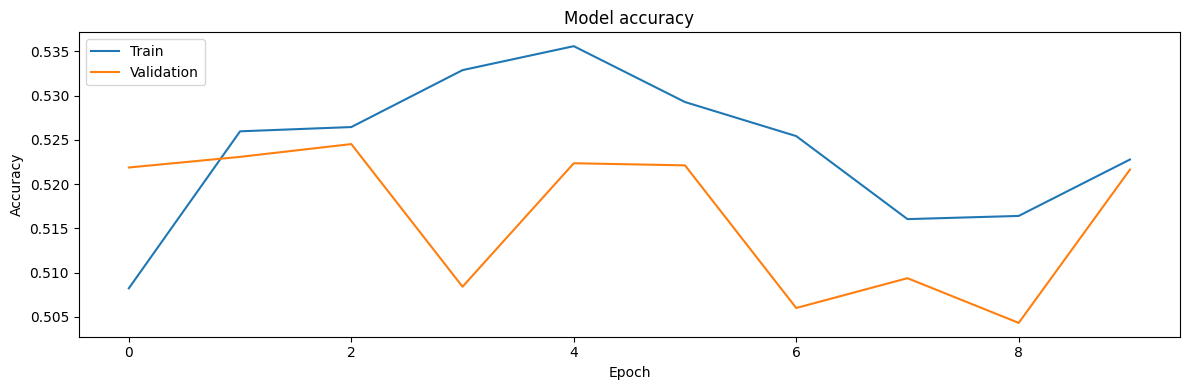

In [38]:
plt.figure(figsize=(12, 4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

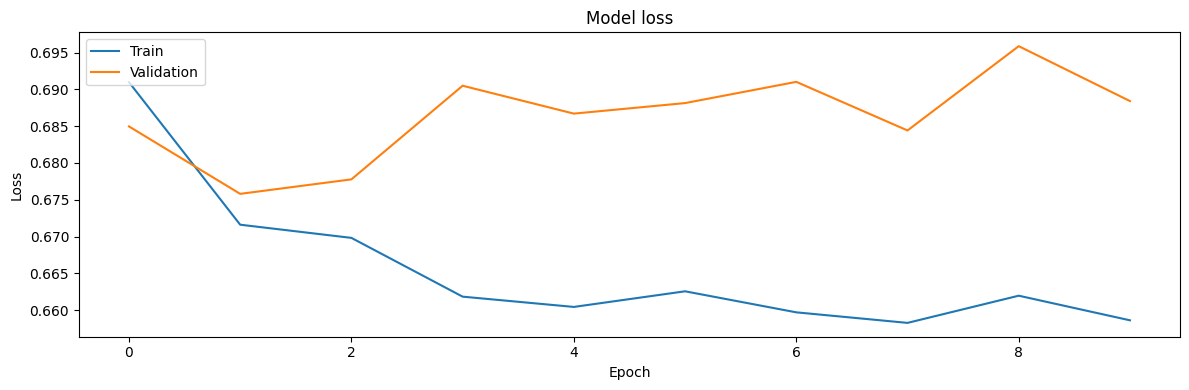

In [48]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
# model evaluation test dataset
def model_evaluation(model,X_test,y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return score

In [36]:
model_evaluation(model,test_padded, test_y)

Test loss: 0.6884139776229858 / Test accuracy: 0.5216346383094788


[0.6884139776229858, 0.5216346383094788]

## Running RNN Network

In [40]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

rnnmodel = Sequential()

rnnmodel.add(Embedding(input_dim=20000, output_dim=128, input_length=max_length))

# SimpleRNN layer
rnnmodel.add(SimpleRNN(128))

rnnmodel.add(Dense(1, activation='sigmoid'))

rnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnnmodel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1037, 128)         2560000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,593,025
Trainable params: 2,593,025
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_rnn = rnnmodel.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 551s 1s/step - loss: 0.6987 - accuracy: 0.4995 - val_loss: 0.6990 - val_accuracy: 0.5111
Epoch 2/10
520/520 [==============================] - 524s 1s/step - loss: 0.6987 - accuracy: 0.5007 - val_loss: 0.6941 - val_accuracy: 0.5077
Epoch 3/10
520/520 [==============================] - 506s 973ms/step - loss: 0.6951 - accuracy: 0.5083 - val_loss: 0.6941 - val_accuracy: 0.5075
Epoch 4/10
520/520 [==============================] - 491s 945ms/step - loss: 0.6947 - accuracy: 0.5108 - val_loss: 0.7050 - val_accuracy: 0.5075
Epoch 5/10
520/520 [==============================] - 474s 912ms/step - loss: 0.6947 - accuracy: 0.5063 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 6/10
520/520 [==============================] - 466s 896ms/step - loss: 0.6942 - accuracy: 0.5103 - val_loss: 0.6919 - val_accuracy: 0.5017
Epoch 7/10
520/520 [==============================] - 470s 904ms/step - loss: 0.6924 - accuracy: 0.5095 - val_loss: 0.6943 - val_a

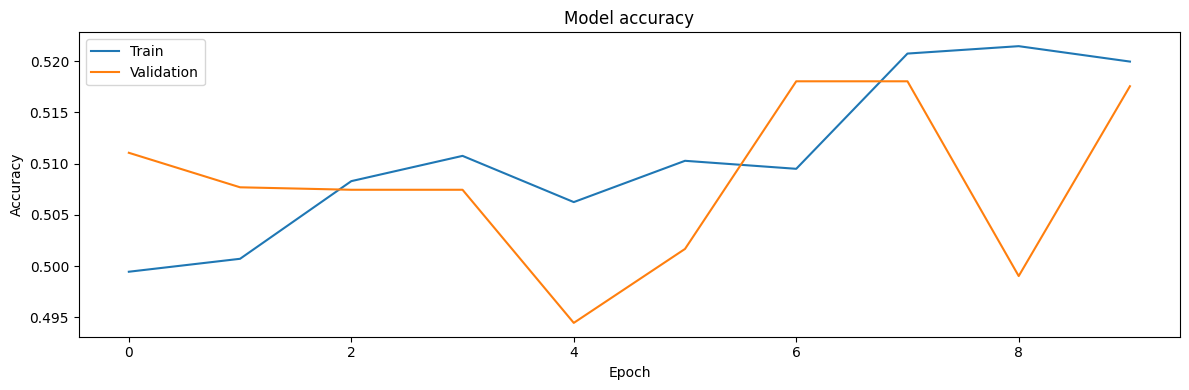

In [44]:
plt.figure(figsize=(12, 4))

plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

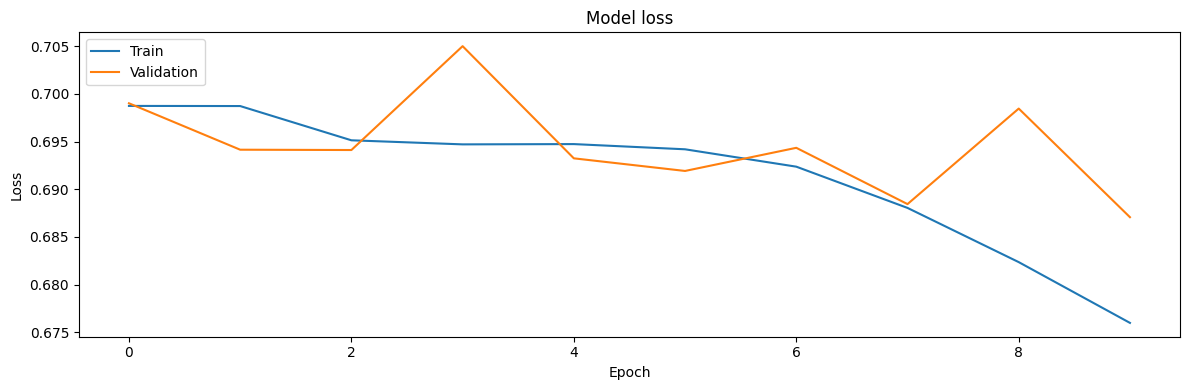

In [47]:
plt.figure(figsize=(12, 4))
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()